## Read data

Remarks
* Focus on process data first. 
* Excel sheets were exported to csv for easier reading.

In [1]:
import pandas as pd
import numpy as np
import altair as alt

# Auto-generate json data files for charts.
_ = alt.data_transformers.enable('json')

Read and clean data. We get: 
* `d_in` influent data
* `d_out` effluent data

In [2]:
d1 = pd.read_csv('./data/influent_lab_analyses.csv', sep=';', decimal ='.')
d2 = pd.read_csv('./data/effluent_lab_analyses.csv', sep=';', decimal ='.')

# Parse datetimes, reset time to midnight.
d1 = d1.assign(date=pd.to_datetime(d1['Datum'], format='%d-%m-%Y', infer_datetime_format=True).dt.normalize())
d1 = d1.drop('Datum', axis=1)
d1 = d1.set_index('date')

d2 = d2.assign(date=pd.to_datetime(d2['Datum'], format='%d-%m-%Y', infer_datetime_format=True).dt.normalize())
d2 = d2.drop('Datum', axis=1)
d2 = d2.set_index('date')

# Clean columns, ensure they are numeric. 
def mapper(col):
    '''Remove special chars and replace blank strings by nan.'''
    col_clean = col.str.replace('<', '').replace(r'^\s+$', np.nan, regex=True)
    return pd.to_numeric(col_clean)
mask = (d1.dtypes == 'object')
d1.loc[:, mask] = d1.loc[:, mask].apply(mapper)
mask = (d2.dtypes == 'object')
d2.loc[:, mask] = d2.loc[:, mask].apply(mapper)

d_in = d1
d_out = d2

In [3]:
print('Sample of influent data:')
d_in.head()


Sample of influent data:


,zwst (mg/l),egv (mS/m),cl (mg/l),so4 (ug/l),nh4 (mg N/l),nkj (mg N/l),no2 (mg N/l),no3 (mg N/l),n (mg N/l),po4o (mg P/l),po4 (mg P/l),czv (mg O2/l),bzv-5 (mg/l),na (mg/l),k (mg/l),ph (pH)
date,,,,,,,,,,,,,,,,
2014-10-01,172.0,716,1920.0,57.0,91.0,110.0,0.584,1.3,112.0,0.31,2.0,1580,6807.5,NaN,NaN,NaN
2014-10-06,91.0,876,2480.0,67.0,54.4,64.0,0.242,1.7,66.0,1.30,2.7,1510,7.5,NaN,NaN,NaN
2014-10-11,66.0,3755,12800.0,65.0,8.0,13.0,6.370,57.1,76.0,1.60,2.8,2080,10207.4,NaN,NaN,NaN
2014-10-16,174.0,2495,8310.0,92.0,14.9,31.0,6.440,27.5,65.0,2.20,4.2,1400,NaN,5600.0,17.0,7.3
2014-10-21,74.0,6308,25100.0,73.0,2.6,12.0,12.600,106.0,130.0,2.50,4.0,2460,1230.0,16300.0,17.0,7.4


In [4]:
print('Sample of effluent data:')
d_out.head()

Sample of effluent data:


,zwst (mg/l),egv (mS/m),cl (mg/l),so4 (mg/l),nh4 (mg N/l),nkj (mg N/l),no2 (mg N/l),no3 (mg N/l),n (mg N/l),po4o (mg P/l),po4 (mg P/l),czv (mg O2/l),bzv-5 (mg/l),na (mg/l),k (mg/l),ph (pH)
date,,,,,,,,,,,,,,,,
2014-10-01,17.0,3650.0,12400.0,666.0,14.4,21.0,0.651,8.1,29.0,0.250,0.70,128.0,9.0,NaN,NaN,8.2
2014-10-06,7.0,2105.0,6560.0,687.0,26.8,32.0,2.450,9.5,44.0,0.097,0.42,113.0,6.0,NaN,NaN,8.2
2014-10-11,39.0,2623.0,8760.0,698.0,10.8,13.0,0.724,7.3,21.0,0.065,0.36,89.0,8.0,NaN,NaN,8.1
2014-10-16,15.0,3210.0,11100.0,471.0,8.3,12.0,0.690,7.5,20.0,0.045,0.18,49.0,5.0,7700.0,7.4,8.1
2014-10-21,11.0,3647.0,13500.0,750.0,4.9,9.6,0.718,7.7,18.0,0.037,0.21,71.0,4.0,9600.0,7.6,8.2


Create charts:
* Based on Altair, see https://altair-viz.github.io/.
* Drag and drop top chart to zoom bottom charts.
* NaN values correspond to missing line segments in the charts.

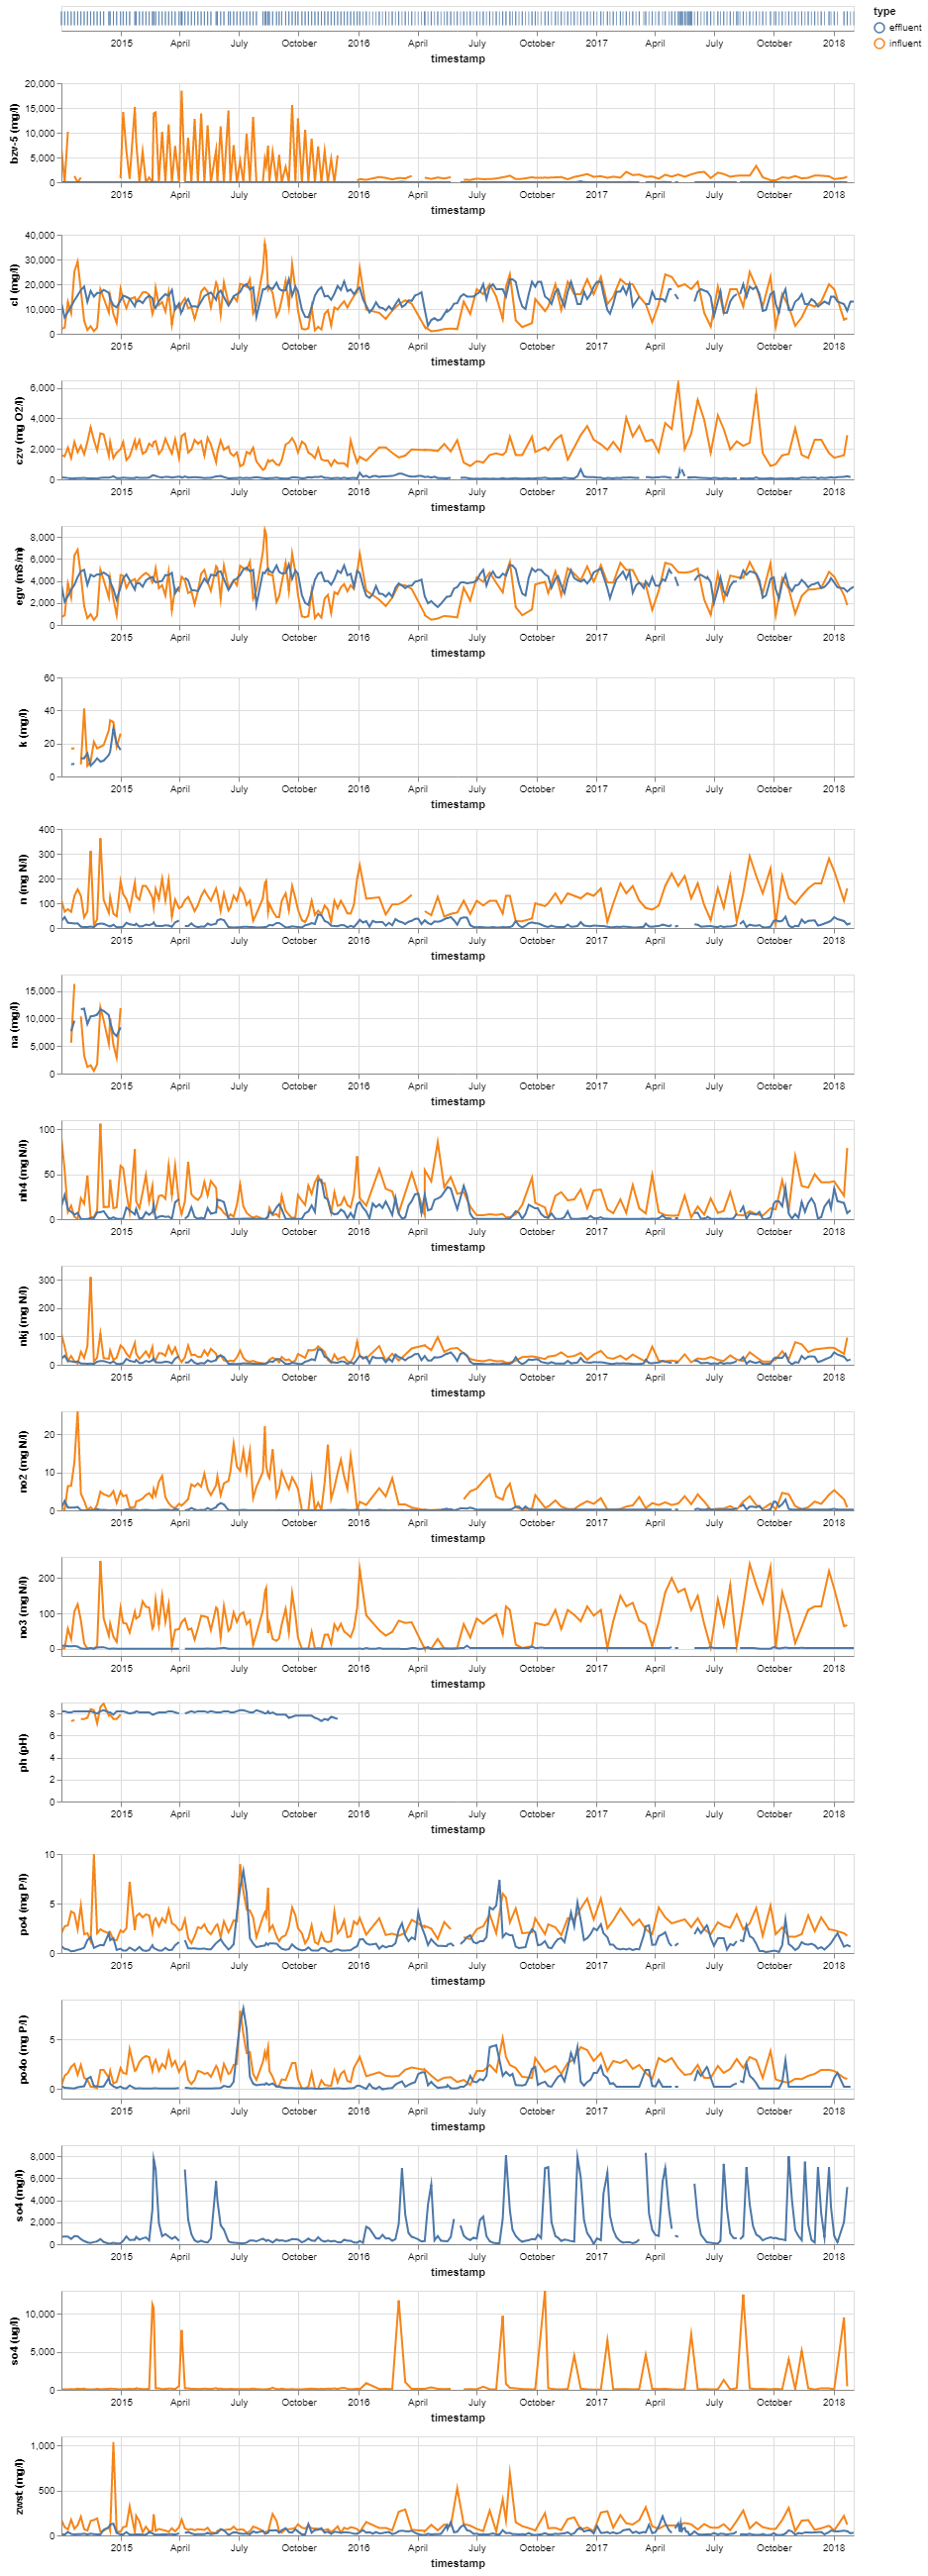

In [5]:
d1 = d_in.assign(type='influent')
d2 = d_out.assign(type='effluent')
d = pd.concat([d1, d2]).assign(timestamp=lambda d: d.index.date)

brush = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(d)
base = base.mark_line()
base = base.properties(width=800, height=100)

chart = alt.vconcat()
mask = ~d.columns.isin(['timestamp', 'type'])
for col in d.columns[mask]:
    chart &= base.encode(
            x=alt.X('timestamp:T', scale={'domain': brush.ref()}),
            y=col+':Q',
            color='type:N'
        )

selection = base.properties(height=25)
selection = selection.mark_tick()
selection = selection.encode(x='timestamp:T')
selection = selection.add_selection(brush)

selection & chart